# Multimodal search with CLIP

In this notebook we show-case SuperDuperDB's functionality for searching with multiple types of data over
the same `VectorIndex`. This comes out very naturally, due to the fact that SuperDuperDB allows
users and developers to add arbitrary models to SuperDuperDB, and (assuming they output vectors) use
these models at search/ inference time, to vectorize diverse queries.

To this end, we'll be using the [CLIP multimodal architecture](https://openai.com/research/clip).

In [1]:
!pip install clip

# Get Data

https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images

Collection of ~3000 product images under Apparel and Footwear category. Two gender types Boys and Girls under Apparel, similarly Men and Women under Footwear.
Each image is identified by an unique ID(ProductId) like 10054.
fashion.csv contains additional details about the products like title, description, category, gender etc.

Download the dataset (350Mb) via Kaggle API

You need to be registered on kaggle first.
Download `kaggle.json`` and put it in the right folder to use kaggle python API package. See instructions in https://www.kaggle.com/docs/api



In [2]:
!pip install kaggle


In [3]:
from pathlib import Path

download_path = Path("fashion-images.zip")
out_path = Path("fashion_images")
data_path = out_path/'data'

In [4]:
!kaggle datasets download -d vikashrajluhaniwal/fashion-images

fashion-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile


with zipfile.ZipFile(download_path, "r") as zip_ref:
    zip_ref.extractall(out_path)



The real images in this dataset are quite large -  1080 x 1440 or even bigger.
This document is for illustration purposes
 downsize to 64×64 for faster running of this notebook. You don't need to do it with your real data


In [6]:
from PIL import Image
from pathlib import Path

def resize_image(image_path, base_size=64):
    with Image.open(image_path) as img:
            width, height = img.size
            if height > width:
                new_height = base_size
                new_width = int(new_height * width / height)
            else:
                new_width = base_size
                new_height = int(new_width * height / width)
            img_resized = img.resize((new_width, new_height))
            img_resized.save(image_path)

# Iterate over all .jpg files in the directory and its subdirectories
for image_path in data_path.glob('**/*.jpg'):
    resize_image(image_path)


Let's read product catalog csv. The images are already on disk so we don't need to load the external Image URL column. Instead we add a field with URI pointing to the local disk storage.

TODO: Duncan, is there a way to make URIs and encoders play togehter so that URI is downloaded and encoded? would be nice to demo it here

In [7]:
import pandas as pd
df = pd.read_csv(data_path/'fashion.csv', usecols=['ProductId', 'Gender', 'Category', 'SubCategory', 'ProductType',
       'Colour', 'Usage', 'ProductTitle', 'Image'])
#df['ImageURI'] = df.apply(lambda row: (data_path/row['Category']/row['Gender']/'Images'/'images_with_product_ids'/row['Image']).absolute().as_uri(), axis=1)
df['ImagePath'] = df.apply(lambda row: str(data_path/row['Category']/row['Gender']/'Images'/'images_with_product_ids'/row['Image']), axis=1)

In [8]:

import pymongo
from superduperdb.misc.superduper import superduper
from superduperdb.models.torch.wrapper import TorchModel
from superduperdb.datalayer.mongodb.query import Collection

from IPython.display import display

database_name = 'ecommerce-fashion'

client = pymongo.MongoClient()
client.drop_database(database_name)
pymongo_db = client[database_name]
db = superduper(pymongo_db)

collection = Collection(name='products')

In order to make this notebook easy to execute an play with, we'll use a sub-sample of the [Tiny-Imagenet
dataset](https://paperswithcode.com/dataset/tiny-imagenet). 

Everything we are doing here generalizes to much larger datasets, with higher resolution images, without
further ado. For such use-cases, however, it's advisable to use a machine with a GPU, otherwise they'll 
be some significant thumb twiddling to do.

To get the images into the database, we use the `Encoder`-`Document` framework. This allows
us to save Python class instances as blobs in the `Datalayer`, but retrieve them as Python objects.
This makes it far easier to integrate Python AI-models with the datalayer.

To this end, SuperDuperDB contains pre-configured support for `PIL.Image` instances. It's also 
possible to create your own encoders.

In [9]:
import PIL
from superduperdb.core.document import Document as SuperDuperDocument
from superduperdb.encoders.pillow.image import pil_image as image_encoder

df['img'] = df['ImagePath'].apply(lambda x: image_encoder(PIL.Image.open(x)))
sdp_documents =  [SuperDuperDocument(my_dict) for my_dict in df.to_dict(orient='records')]
db.execute(collection.insert_many(sdp_documents, encoders=(image_encoder,)))

INFO:root:found 0 uris


(<pymongo.results.InsertManyResult at 0x291381ab0>,
 TaskWorkflow(database=<superduperdb.datalayer.base.datalayer.Datalayer object at 0x28fa982b0>, G=<networkx.classes.digraph.DiGraph object at 0x291381bd0>))

The wrapped python dictionaries may be inserted directly to the `Datalayer`:

We can verify that the images are correctly stored:

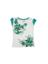

In [19]:
x = db.execute(collection.find_one())['img'].x
x

We now can wrap the CLIP model, to ready it for multimodel search. It involves 2 components:

- text-encoding
- visual-encoding

Once we have installed both parts, we will be able to search with both images and text for 
matching items:

In [11]:
import torch
import clip

from superduperdb.encoders.torch.tensor import tensor as tensor_encoder
from superduperdb.models.torch.wrapper import TorchModel

my_tensor_encoder = tensor_encoder(torch.float, shape=(512,))

model, preprocess = clip.load("ViT-B/32", device='cpu')

text_model = TorchModel(
    identifier='clip_text',
    object=model,
    preprocess=lambda x: clip.tokenize(x)[0],
    forward_method='encode_text',
    encoder=my_tensor_encoder
)

visual_model = TorchModel(
    identifier='clip_image',
    preprocess=preprocess,
    object=model.visual,
    encoder=my_tensor_encoder,
)

Let's verify this works:

In [12]:
text_model.predict('this is a test', one=True)

tensor([ 1.5430e-01,  8.3420e-02, -8.6218e-02, -2.4812e-01, -9.0192e-02,
        -1.7874e-01,  7.9648e-02, -1.4377e+00,  9.5242e-02,  2.9510e-01,
         4.2067e-03,  2.5638e-01, -2.1602e-02,  1.5736e-02,  1.9318e-01,
        -1.6119e-01,  3.6999e-01,  2.2594e-02, -5.7204e-02, -1.9817e-01,
        -7.5303e-03, -3.2254e-01,  2.7348e-01, -3.5396e-01, -1.9037e-01,
         1.0515e-01, -2.4183e-02,  1.0074e-01, -8.8070e-02,  2.6366e-02,
        -2.7967e-01, -2.9460e-01,  2.1931e-02,  1.1821e-01,  8.7240e-02,
         1.1945e-01, -6.0588e-04, -1.0101e-01, -1.0430e-01, -2.0626e-01,
        -1.3790e-01, -3.9173e-02,  7.5542e-03,  1.3866e-01, -1.1169e-01,
         1.1691e-01, -1.8521e-01,  2.9997e-02,  1.0280e-01,  1.1497e-01,
        -1.0389e-01,  5.0075e-02,  3.1277e-01, -1.7357e-01,  4.6908e-02,
        -9.6960e-02,  7.7737e-02,  4.9119e-03, -2.9044e-01, -3.6214e-02,
         3.3161e-01,  4.0403e-02, -3.6718e-02,  3.3114e-02,  1.3841e-01,
         1.1665e-01, -1.8533e-01,  1.4537e-01,  1.7

Similar procedure with the visual part, which takes `PIL.Image` instances as inputs.

In [13]:
visual_model = TorchModel(
    identifier='clip_image',
    preprocess=preprocess,
    object=model.visual,
    encoder=my_tensor_encoder,
)

In [14]:
visual_model.predict(x, one=True)

tensor([ 3.0578e-02, -1.6221e-01, -5.5376e-02,  7.8390e-02, -1.2022e-01,
         5.0640e-01,  1.0211e-01,  2.2622e-01,  3.2397e-01,  6.2261e-02,
         3.5964e-01,  2.9982e-01,  6.0377e-02,  8.5026e-02, -5.3123e-01,
         1.3775e-01,  3.2034e-01,  4.3730e-01,  1.9380e-01, -1.1651e-01,
        -1.3150e-01, -5.1755e-01,  6.1077e-01, -2.2255e-01, -7.0276e-01,
         3.0484e-01,  6.1931e-02, -5.8035e-01,  2.2770e-01, -6.4251e-01,
         3.3999e-01, -1.7397e-02,  7.0908e-02, -9.2297e-02, -7.9436e-02,
        -3.1447e-01, -3.1228e-01,  2.3822e-02, -5.0216e-01,  1.4930e+00,
         8.4230e-02, -2.3044e-02, -1.1477e-01,  3.5502e-02, -1.2837e-01,
        -9.5825e-01, -5.2861e-01,  1.8252e-01,  6.3224e-01, -3.9892e-01,
         4.7636e-01, -2.0618e-01,  1.2273e-01,  3.8639e-01, -1.0503e-01,
         3.0455e-01, -2.9782e-02,  3.6526e-02, -2.8694e-01,  3.2250e-01,
         5.4747e-01, -2.3506e-01, -9.4274e-02, -2.6075e-01, -2.7888e-01,
         1.8752e-01, -8.9015e-02, -3.2810e-01, -3.7

Now let's create the index for searching by vector. We register both models with the index simultaneously,
but specifying that it's the `visual_model` which will be responsible for creating the vectors in the database
(`indexing_watcher`). The `compatible_watcher` specifies how one can use an alternative model to search 
the vectors. By using models which expect different types of index, we can implement multimodal search
without further ado.

In [15]:
from superduperdb.core.vector_index import VectorIndex
from superduperdb.core.watcher import Watcher

db.add(
    VectorIndex(
        'my-index',
        indexing_watcher=Watcher(
            model=visual_model,
            key='img',
            select=collection.find(),
        ),
        compatible_watcher=Watcher(
            model=text_model,
            key='text',
            active=False,
        )
    )
)

Computing chunk 0/0


100%|██████████| 2906/2906 [01:46<00:00, 27.39it/s]
INFO:root:loading hashes: 'my-index'
/Users/levkonstantinovskiy/Documents/GitHub/new/superduperdb-stealth/superduperdb/encoders/torch/tensor.py:25: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  return torch.from_numpy(array)


[]

We can now demonstrate searching by text for images:

In [32]:
filter_query = {
        
        'Category': 'Footwear',
        'ProductType': 'Tops',
  }
out = db.execute(
    collection.like(SuperDuperDocument({'text': 'running shoes'}), vector_index='my-index', n=3).find(filter_query)
)
for r in out:
    display(r['img'].x)

In [33]:

def _extract(out):
    return [(row['img'].x) for row in out]

def query_db(text, category, sub_category, product_type, colour, usage):
    filter_query = {}
    all_label = 'All'
    populated =  lambda x: (not x==all_label) and x
    if populated(category):
        filter_query['Category'] = category
    if populated(sub_category):
        filter_query['SubCategory'] = sub_category
    if populated(product_type):
        filter_query['ProductType'] = product_type
    if populated(all_label):
        filter_query['Colour'] = colour
    if populated(all_label):
        filter_query['Usage'] = usage

    code = f"""
    import clip 
    import pymongo
    
    from superduperdb.misc.superduper import superduper
    from superduperdb.datalayer.mongodb.query import Collection
    from superduperdb.core.document import Document as D
    

    db = pymongo.MongoClient().documents
    db = superduper(db)

    collection = Collection(name='tiny-imagenet')

    cursor = db.execute(collection.like(D'{'text:{text}'}'), vector_index='{'my-index'}', n=20).find({filter_query})
    

    """

    similar_doc = SuperDuperDocument({'text':text})    
    cursor = collection.like(similar_doc, vector_index='my-index', n=20).find(filter_query)
    results = db.execute(cursor)
    return (_extract(results), code)





In [34]:
import gradio as gr

def get_unique_values(column_name, df=df):
    return  ['All'] + df[column_name].unique().tolist() 



category_values = get_unique_values('Category')
sub_category_values = get_unique_values('SubCategory')
product_type_values = get_unique_values('ProductType')
colour_values = get_unique_values('Colour')
usage_values = get_unique_values('Usage')



with gr.Blocks() as demo:
    with gr.Tab("Multi-modal search"):
        with gr.Row():
            
            text_query = gr.Textbox(value="Heels", label='Search query', show_label=True)
            
            category = gr.Dropdown(category_values, label='Category')
            sub_category = gr.inputs.Dropdown(sub_category_values, label='SubCategory')
            product_type = gr.inputs.Dropdown(product_type_values, label='ProductType')
            colour = gr.inputs.Dropdown(colour_values, label='Colour')
            usage = gr.inputs.Dropdown(usage_values, label='Usage')
            
        with gr.Row():
            b2 = gr.Button("Submit")
        with gr.Row():
            code = gr.Code(label="Code", language="python")
        with gr.Row():
            
            openai_gallery = gr.Gallery(
                    label="Similar images from CLIP", show_label=True, elem_id="gallery"
                ).style(columns=[6], rows=[3], object_fit="contain", height="auto")

            
        b2.click(query_db, inputs=[text_query, category, sub_category, product_type, colour, usage], outputs=[openai_gallery,  code])
        
demo.launch()

/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/ipykernel_78227/573181240.py:23: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  sub_category = gr.inputs.Dropdown(sub_category_values, label='SubCategory')
/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/ipykernel_78227/573181240.py:23: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  sub_category = gr.inputs.Dropdown(sub_category_values, label='SubCategory')
/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/ipykernel_78227/573181240.py:24: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  product_type = gr.inputs.Dropdown(product_type_values, label='ProductType')
/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/ipykernel_78227/573181240.py:24: GradioDeprecationWarning: `optional` para

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.
